#### Vivian Xia

# Kaggle Fashion MNIST

The dataset consists of 70,000 gray-scale images. Each image is 28 pixels in height and 28 pixels in width. Pixel-value is an integer between 0 and 255. 

The goal is to classify the images into its corresponding fashion items class. There are ten classes including t-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. 

## Import packages and data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/MSDS462/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist
!ls -l /content
!unzip /content/fashionmnist.zip

100% 68.8M/68.8M [00:00<00:00, 365MB/s]
100% 68.8M/68.8M [00:00<00:00, 358MB/s]
total 70436
drwx------ 5 root root     4096 Apr  2 03:42 drive
-rw-r--r-- 1 root root 72114846 Apr  2 03:44 fashionmnist.zip
drwxr-xr-x 1 root root     4096 Mar 23 14:22 sample_data
Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


## Functions

In [ ]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")


def subplot_plot_digits(cl_a, cl_b):
  print("0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot \n")
  X_aa = x_test[(y_test == cl_a) & (pred == cl_a)]
  X_ab = x_test[(y_test == cl_a) & (pred == cl_b)]
  X_ba = x_test[(y_test == cl_b) & (pred == cl_a)]
  X_bb = x_test[(y_test == cl_b) & (pred == cl_b)]

  plt.figure(figsize=(8,8))

  p1 = plt.subplot(221)
  p2 = plt.subplot(222)
  p3 = plt.subplot(223)
  p4 = plt.subplot(224)

  plot_digits(X_aa[:25], p1, images_per_row=5);
  plot_digits(X_ab[:25], p2, images_per_row=5);
  plot_digits(X_ba[:25], p3, images_per_row=5);
  plot_digits(X_bb[:25], p4, images_per_row=5);


  p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
  p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
  p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
  p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

  plt.show()

## Load data

In [ ]:
#train
train_path = "/content/fashion-mnist_train.csv"
data_train = pd.read_csv(train_path)
num_classes = data_train.shape[0] 
y_train = np.array(data_train.iloc[:, 0])
x_train = np.array(data_train.iloc[:, 1:])
x_train = x_train.reshape(num_classes, 28, 28, 1)

#test
test_path = "/content/fashion-mnist_test.csv"
data_test = pd.read_csv(test_path)
num_classes = data_test.shape[0] 
y_test = np.array(data_test.iloc[:, 0])
x_test = np.array(data_test.iloc[:, 1:])
x_test = x_test.reshape(num_classes, 28, 28, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


## Exploratory data analysis

Labels:
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [2 9 6 0 3 4 4 5 4 8]



In [ ]:
train_freq = Counter(y_train).most_common()
train_freq

[(2, 6000),
 (9, 6000),
 (6, 6000),
 (0, 6000),
 (3, 6000),
 (4, 6000),
 (5, 6000),
 (8, 6000),
 (7, 6000),
 (1, 6000)]

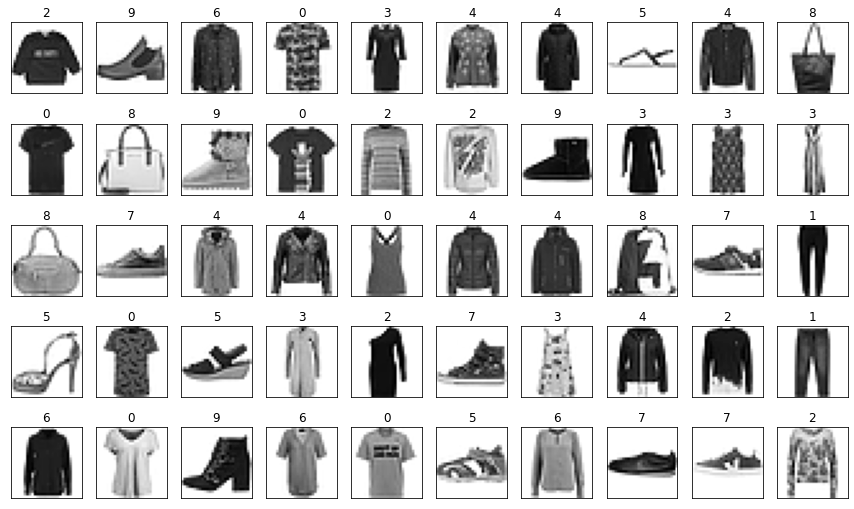

In [ ]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

## Preprocess the data

In [ ]:
# normalize the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=.1,random_state=42,shuffle=True)

print(x_train.shape, x_val.shape, x_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


## Experiment 1

### Build model

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(units=10, activation=tf.nn.relu))
model.add(layers.Dense(units=20, activation=tf.nn.relu))
model.add(layers.Dense(10, activation=tf.nn.softmax, name="output_layer")) #10 labels

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 8,280
Trainable params: 8,280
Non-trainable params: 0
_________________________________________________________________


### Compile model

The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment1"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 11s 5ms/step - loss: 0.6678 - accuracy: 0.7662 - val_loss: 0.4994 - val_accuracy: 0.8242
Epoch 2/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4771 - accuracy: 0.8320 - val_loss: 0.4488 - val_accuracy: 0.8402
Epoch 3/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4477 - accuracy: 0.8416 - val_loss: 0.4422 - val_accuracy: 0.8428
Epoch 4/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4308 - accuracy: 0.8472 - val_loss: 0.4155 - val_accuracy: 0.8565
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4188 - accuracy: 0.8530 - val_loss: 0.3995 - val_accuracy: 0.8567
Epoch 6/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4110 - accuracy: 0.8550 - val_loss: 0.4024 - val_accuracy: 0.8568
Epoch 7/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4042 - accuracy: 0.8584 - val_loss: 0.3977 - val_accuracy

### Test model

In [ ]:
experiment = "Experiment1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.4163 - accuracy: 0.8584
test acc: 0.8583999872207642, test loss: 0.41625064611434937


### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

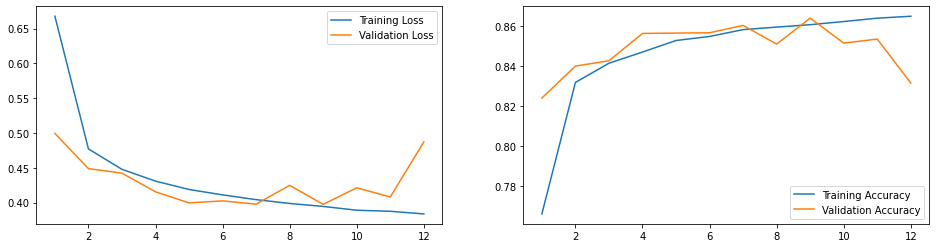

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

Training and validation graphs start to overfit, but early stopping callback helped to regularize it.

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

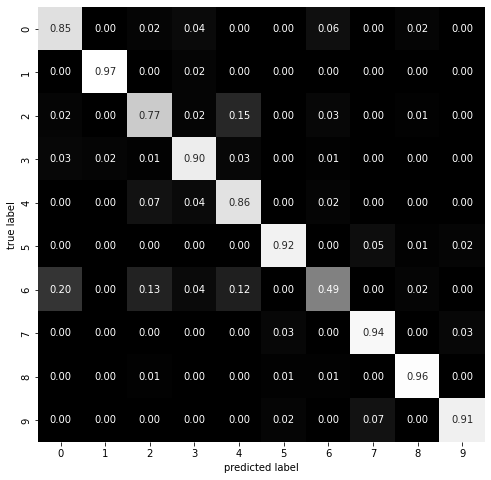

In [ ]:
plot_confusion_matrix(norm_conf_mx)

The classification rates are good for each class, ranging from 0.85 to 0.97, except the classes 2 and 6. Class 2 is often mislabeled as 4. Class 6 is often mislabeled as a 4. 

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



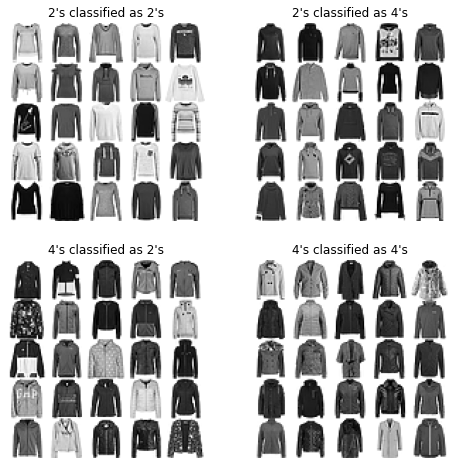

In [ ]:
subplot_plot_digits(2,4)

Class 2 and 4 are pullovers and coats respectively. From the plot, it can be seen that the two types of tops do look very similar to each other, so it makes sense that the model could not easily discriminate between the two. 

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



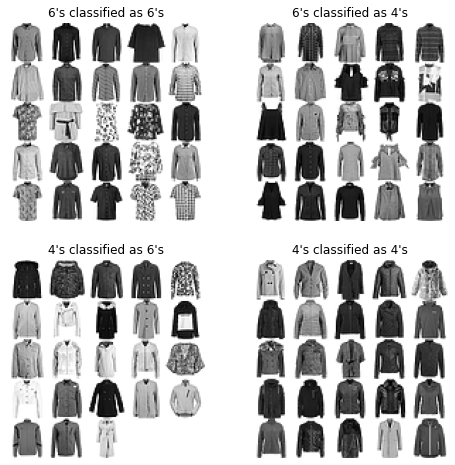

In [ ]:
subplot_plot_digits(6,4)

Similarly, Class 6 and 4, shirt and coat respectively, are hard to discriminate even to the human eye.

## Experiment 2

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Flatten())

model.add(layers.Dense(units=20, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 10)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                33820     
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 34,130
Trainable params: 34,130
Non-trainable params: 0
__________________________________________________

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment2"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 13s 3ms/step - loss: 0.5066 - accuracy: 0.8217 - val_loss: 0.4048 - val_accuracy: 0.8528
Epoch 2/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3375 - accuracy: 0.8803 - val_loss: 0.3085 - val_accuracy: 0.8922
Epoch 3/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2996 - accuracy: 0.8950 - val_loss: 0.2966 - val_accuracy: 0.8975
Epoch 4/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2779 - accuracy: 0.9014 - val_loss: 0.3009 - val_accuracy: 0.8942
Epoch 5/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2619 - accuracy: 0.9068 - val_loss: 0.2918 - val_accuracy: 0.9005
Epoch 6/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2495 - accuracy: 0.9112 - val_loss: 0.2807 - val_accuracy: 0.9030
Epoch 7/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2385 - accuracy: 0.9155 - val_loss: 0.2761 - val_accuracy

### Test model

In [ ]:
experiment = "Experiment2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.2574 - accuracy: 0.9108
test acc: 0.9107999801635742, test loss: 0.25735369324684143


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

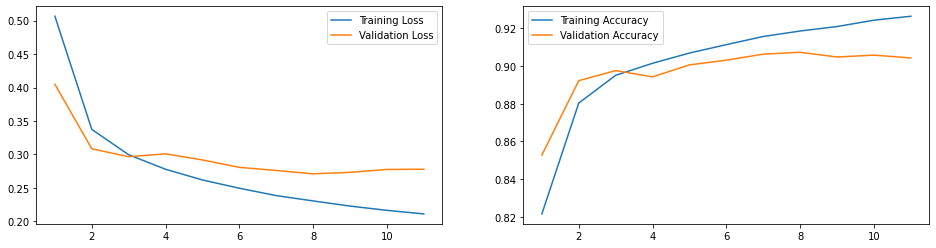

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training and validation graphs have a small difference, so there is no overfitting. But if there is more complexity added, there should be some regularization to it. 

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

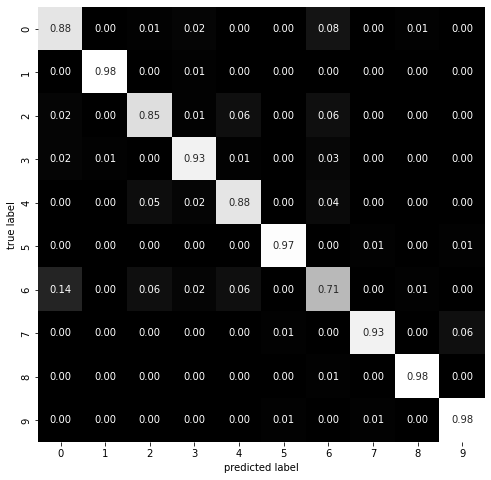

In [ ]:
plot_confusion_matrix(norm_conf_mx)

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



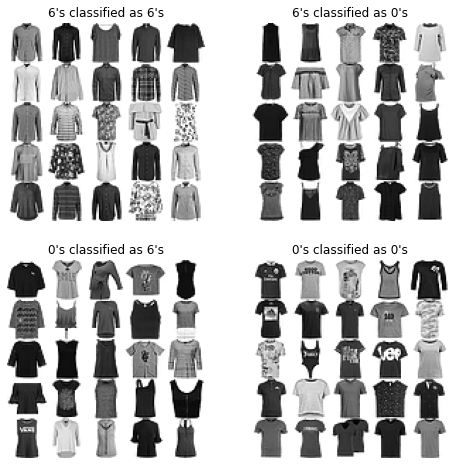

In [ ]:
subplot_plot_digits(6,0)

## Experiment 3

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 22)        220       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 22)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 22)        0         
                                                                 
 flatten_2 (Flatten)         (None, 3718)              0         
                                                                 
 dense_3 (Dense)             (None, 35)                130165    
                                                                 
 output_layer (Dense)        (None, 10)                360       
                                                      

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment3"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4857 - accuracy: 0.8265 - val_loss: 0.3510 - val_accuracy: 0.8775
Epoch 2/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3387 - accuracy: 0.8806 - val_loss: 0.3035 - val_accuracy: 0.8930
Epoch 3/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3039 - accuracy: 0.8917 - val_loss: 0.2910 - val_accuracy: 0.8930
Epoch 4/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2834 - accuracy: 0.8983 - val_loss: 0.2786 - val_accuracy: 0.8993
Epoch 5/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2698 - accuracy: 0.9043 - val_loss: 0.2857 - val_accuracy: 0.8995
Epoch 6/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2561 - accuracy: 0.9082 - val_loss: 0.2726 - val_accuracy: 0.9027
Epoch 7/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2495 - accuracy: 0.9116 - val_loss: 0.2561 - val_accuracy:

### Test model

In [ ]:
experiment = "Experiment3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.9152
test acc: 0.9151999950408936, test loss: 0.24427030980587006


This model was able to discriminate between the classes only 0.01 more accurately than that of the previous model. It also had longer processing time and more parameters to train. 

### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

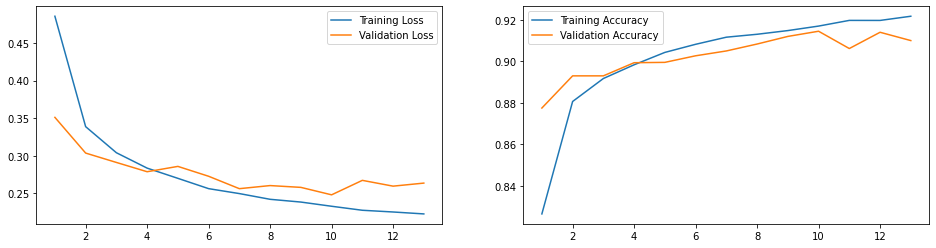

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

There does not seem to be overfitting.

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

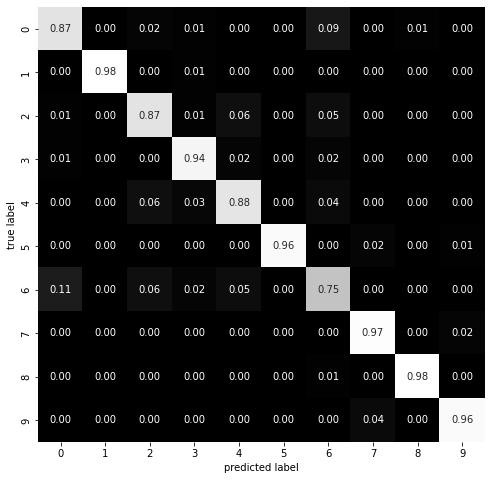

In [ ]:
plot_confusion_matrix(norm_conf_mx)

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



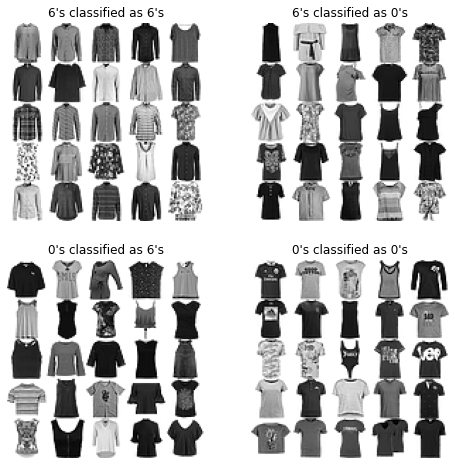

In [ ]:
subplot_plot_digits(6,0)

## Experiment 4

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu)) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 10)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 10)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 22)        2002      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 22)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 22)         

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment4"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 10s 5ms/step - loss: 0.6843 - accuracy: 0.7441 - val_loss: 0.4581 - val_accuracy: 0.8380
Epoch 2/50
1688/1688 [==============================] - 8s 5ms/step - loss: 0.4810 - accuracy: 0.8231 - val_loss: 0.3838 - val_accuracy: 0.8618
Epoch 3/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4230 - accuracy: 0.8444 - val_loss: 0.3555 - val_accuracy: 0.8728
Epoch 4/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3911 - accuracy: 0.8573 - val_loss: 0.3812 - val_accuracy: 0.8580
Epoch 5/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3807 - accuracy: 0.8626 - val_loss: 0.3148 - val_accuracy: 0.8922
Epoch 6/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3683 - accuracy: 0.8664 - val_loss: 0.3376 - val_accuracy: 0.8748
Epoch 7/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3610 - accuracy: 0.8686 - val_loss: 0.3154 - val_accuracy

### Test model

In [ ]:
experiment = "Experiment4"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8907
test acc: 0.8906999826431274, test loss: 0.31215962767601013


### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

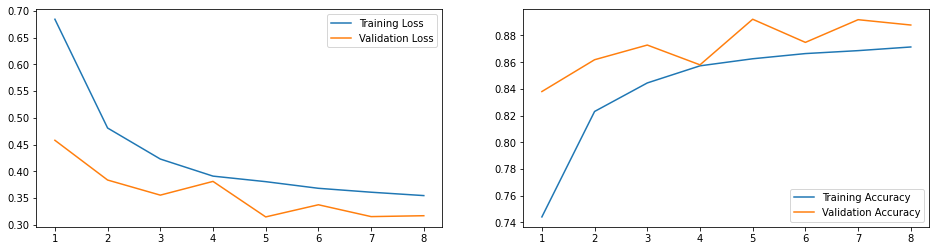

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

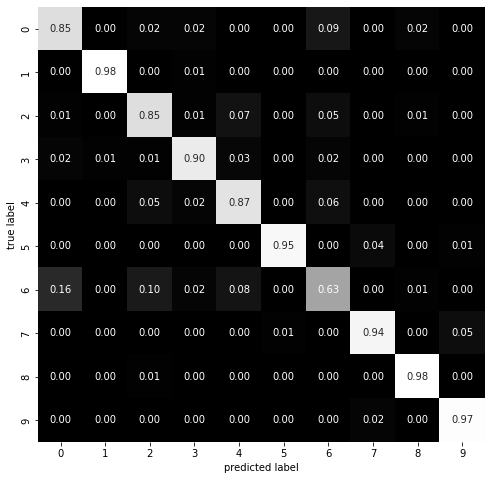

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Experiment 5

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))  
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 22)        2002      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 22)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 22)        0         
                                                                 
 flatten_4 (Flatten)         (None, 3168)              0         
                                                                 
 dense_5 (Dense)             (None, 35)                110915    
                                                      

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment5"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 8s 4ms/step - loss: 0.4620 - accuracy: 0.8344 - val_loss: 0.3221 - val_accuracy: 0.8882
Epoch 2/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3178 - accuracy: 0.8866 - val_loss: 0.2778 - val_accuracy: 0.9025
Epoch 3/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2773 - accuracy: 0.9006 - val_loss: 0.2918 - val_accuracy: 0.8922
Epoch 4/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2534 - accuracy: 0.9102 - val_loss: 0.2563 - val_accuracy: 0.9105
Epoch 5/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2388 - accuracy: 0.9149 - val_loss: 0.2422 - val_accuracy: 0.9167
Epoch 6/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2281 - accuracy: 0.9190 - val_loss: 0.2360 - val_accuracy: 0.9160
Epoch 7/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2177 - accuracy: 0.9221 - val_loss: 0.2628 - val_accuracy:

### Test model

In [ ]:
experiment = "Experiment5"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.2327 - accuracy: 0.9151
test acc: 0.9150999784469604, test loss: 0.23269714415073395


### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

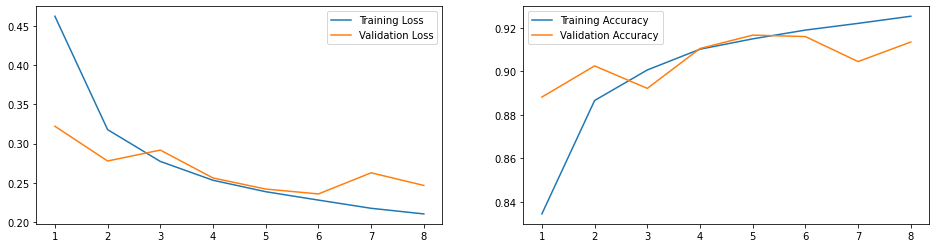

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training and validation graphs are similar so there is not indication of overfitting. 

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

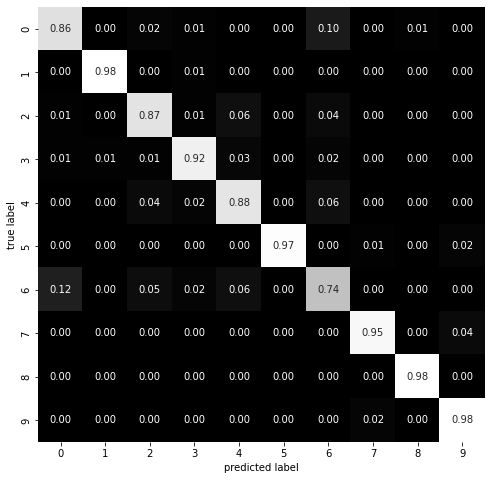

In [ ]:
plot_confusion_matrix(norm_conf_mx)

The classification rates are similar to those of Experiment 3.

## Experiment 6

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=20, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))  
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=48, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 20)        200       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        5792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 48)                221232    
                                                      

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment6"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 8s 4ms/step - loss: 0.4323 - accuracy: 0.8450 - val_loss: 0.3190 - val_accuracy: 0.8845
Epoch 2/50
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2892 - accuracy: 0.8965 - val_loss: 0.2684 - val_accuracy: 0.9073
Epoch 3/50
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2507 - accuracy: 0.9094 - val_loss: 0.2492 - val_accuracy: 0.9135
Epoch 4/50
1688/1688 [==============================] - 12s 7ms/step - loss: 0.2290 - accuracy: 0.9180 - val_loss: 0.2317 - val_accuracy: 0.9200
Epoch 5/50
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2166 - accuracy: 0.9216 - val_loss: 0.2421 - val_accuracy: 0.9135
Epoch 6/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2103 - accuracy: 0.9257 - val_loss: 0.2467 - val_accuracy: 0.9122
Epoch 7/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2008 - accuracy: 0.9287 - val_loss: 0.2384 - val_accurac

### Test model

In [ ]:
experiment = "Experiment6"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/FashionMNIST_Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.2256 - accuracy: 0.9201
test acc: 0.9200999736785889, test loss: 0.2255987524986267


### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

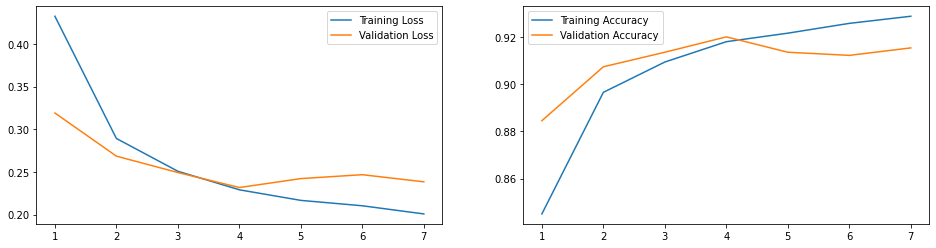

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The model starts to overfit, but the values between training and validation are still similar so no overfitting yet. 

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

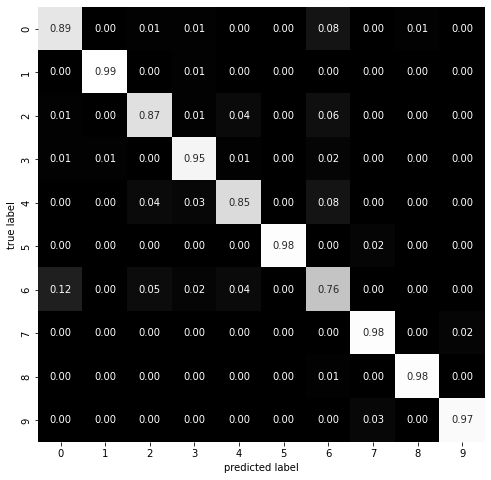

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Conclusion

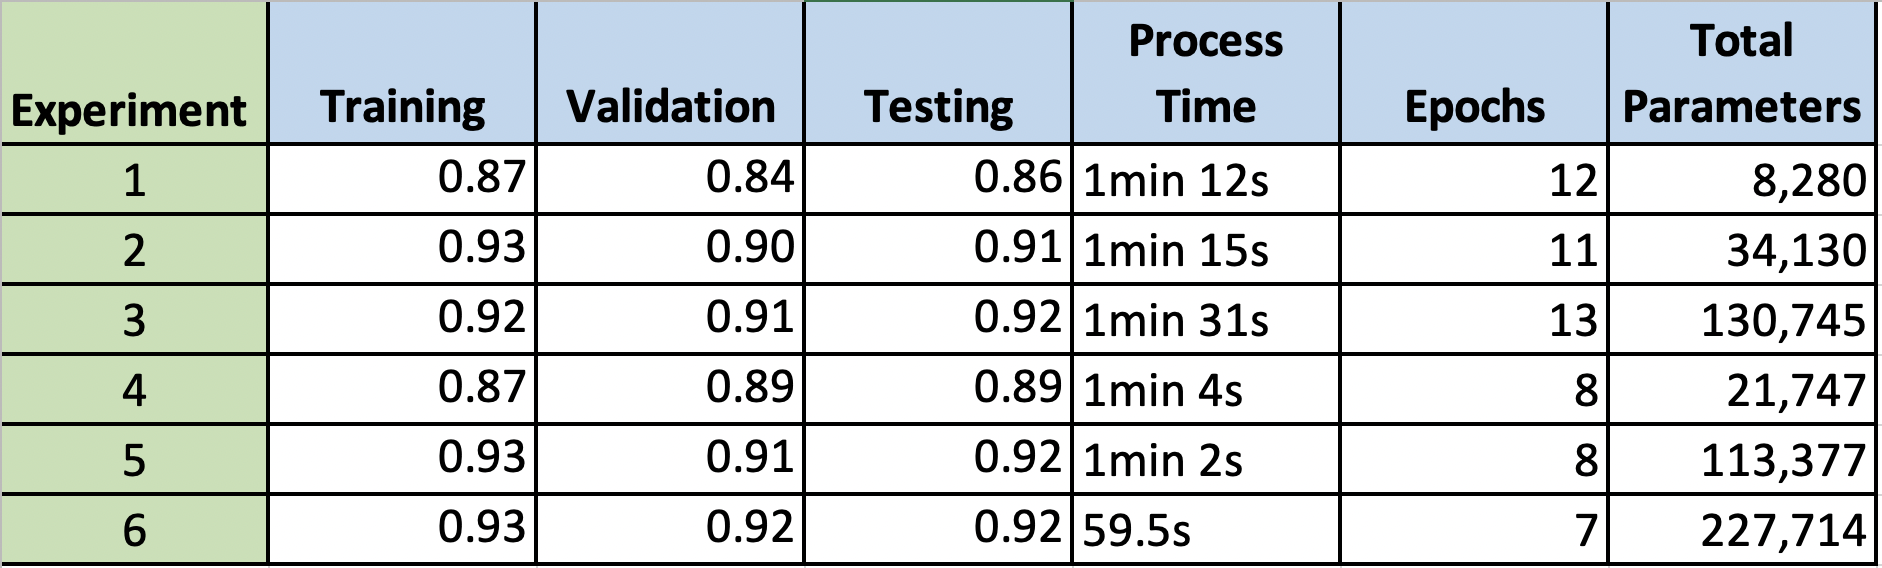

Experiment 1 used an MLP model architechture with only Dense layers. Experiment 2 through 6 used CNN model architechture which evidently was able to extract more relevant and discriminative spatial correlations or features from the images to help with classifying each image correctly. 

The best test accuracy was 0.92, but it comes at a cost of processing time and number of trainable parameters. Therefore, Experiment 2 is the recommended model because there are less parameters that need to be trained with a small cost of 0.01 accuracy. A recommendation is to the combine Class 6, shirts, and 0, t-shirt/top to improve overall accuaracy as it is hard for even a human to decipher the two classes. 